# Setup

In [1]:
#Common imports
import numpy as np
import os
import sys

#To make outputs more consistent
np.random.seed(42)

#To Save & Load Models
import pickle

#To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as pt
import seaborn as sns
sns.set(font_scale=1)

pt.rcParams['axes.labelsize'] = 14
pt.rcParams['xtick.labelsize'] = 12
pt.rcParams['ytick.labelsize'] = 12

#Folder Directory Structure
PROJECT_ROOT_DIR ='.'
PROJECT_FOLDER = 'titanic_kaggle'
PROJECT_ID='end_to_end_project_titanic_kaggle'
PROJECT_OUTPUT_PATH = os.path.join(PROJECT_ROOT_DIR,'model',PROJECT_ID)


def save_fig(fig_id,tight_layout=True,fig_extension='png',resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(PROJECT_OUTPUT_PATH)
    path = os.path.join(PROJECT_OUTPUT_PATH,fig_id + '.' + fig_extension)
    print("Saving Figure : {}".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension,dpi=resolution)
#Saving the Model
import pickle

def save_model(model,model_name):
    if not os.path.exists(PROJECT_OUTPUT_PATH):
        os.makedirs(PROJECT_OUTPUT_PATH)
    model_file = os.path.join(PROJECT_OUTPUT_PATH,model_name+'.pkl')
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    
def load_model(model,model_name):
    model_file = os.path.join(PROJECT_OUTPUT_PATH,model_name+'.pkl')
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
    return model

### Step 1 : Download the Data

In [2]:
import tarfile
from six.moves import urllib
from six.moves import urllib

#Server Location
DOWNLOAD_ROOT = "https://www.kaggle.com/c/3136/download/"
TITANIC_PATH = os.path.join("data", PROJECT_FOLDER)
TITANIC_GENDER_SUBMISSION = DOWNLOAD_ROOT + "gender_submission.csv"
TITANIC_TRAIN_SET = DOWNLOAD_ROOT + "train.csv"
TITANIC_TEST_SET = DOWNLOAD_ROOT + "test.csv"

def fetch_data(file='train.csv',url=TITANIC_TRAIN_SET,path=TITANIC_PATH,):
    print('URL to Download : {}'.format(url))
    print('Path to Download : {} '.format(path))
    if not os.path.isdir(path):
        os.makedirs(path)
    csv_path =  os.path.join(path,file)
    if not os.path.exists(csv_path):
        print('Downloading data ...')
        urllib.request.urlretrieve(url, csv_path)

#Downloading & Extract the data
fetch_data()

URL to Download : https://www.kaggle.com/c/3136/download/train.csv
Path to Download : data\titanic_kaggle 


### Step 2 - Load Data

In [3]:
import pandas as pd

def load_data(path=TITANIC_PATH,file='train.csv'):
    data_file = os.path.join(path,file)
    return pd.read_csv(data_file)

#Load data
print('Loading the Data...')
titanic = load_data()
#Verift the data
titanic.head(2)

Loading the Data...


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Step 3 - Train & Test Data Set

In [4]:
titanic_train = load_data(file='train.csv')
titanic_test = load_data(file='test.csv')
print('Titanic Training Data : {}'.format(titanic_train.shape))
print('Titanic Test Data : {}'.format(titanic_test.shape))

Titanic Training Data : (891, 12)
Titanic Test Data : (418, 11)


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Step 3 - Data Visualization & Inspection

#### Features

survival:   Survival
PassengerId: Unique Id of a passenger.
pclass: Ticket class    
sex:    Sex 
Age:    Age in years    
sibsp:  # of siblings / spouses aboard the Titanic  
parch:  # of parents / children aboard the Titanic  
ticket: Ticket number   
fare:   Passenger fare  
cabin:  Cabin number    
embarked:   Port of Embarkation

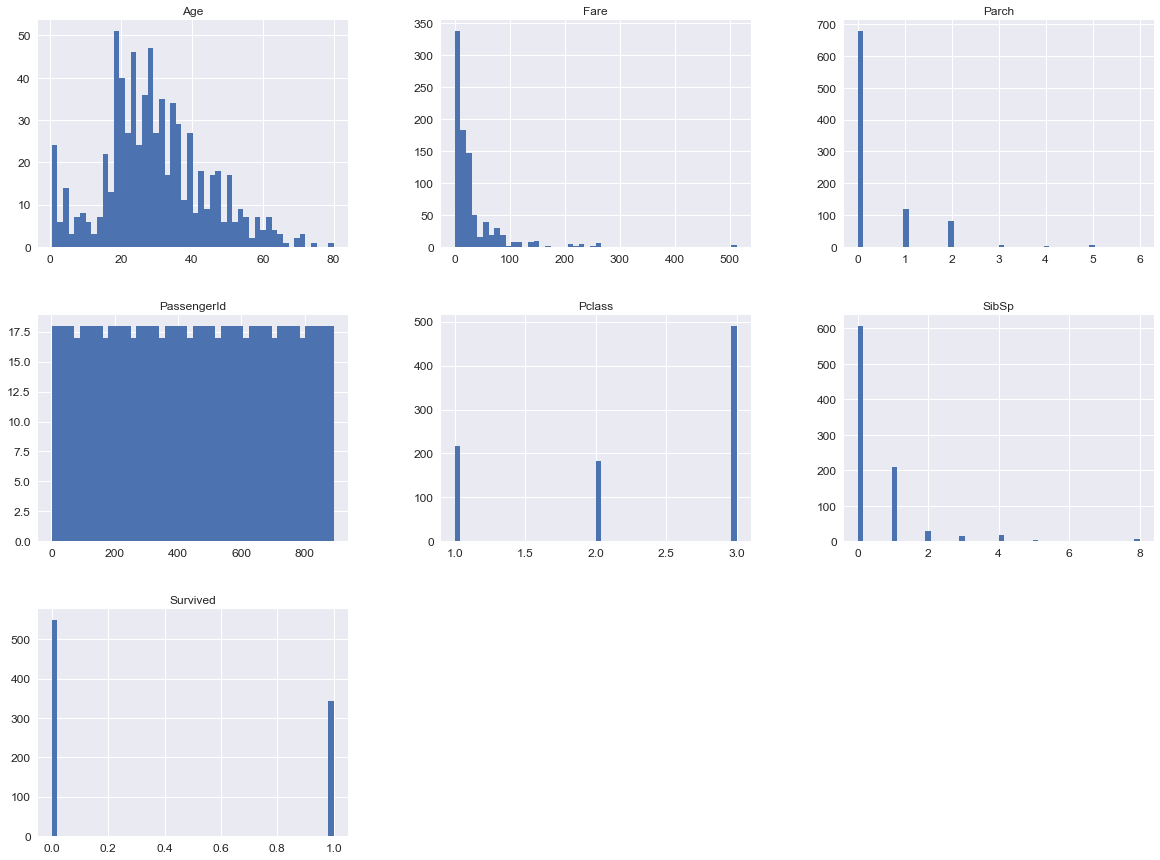

In [7]:
#We can see the graphical distribution too as follows 
import matplotlib.pyplot as plt
#Vertical Axis has number of instances
#Horizontal Axis has values of the attributes
titanic.hist(bins=50,figsize=(20,15))
plt.show()

We see that age and fare are on completely different scale so we do feature scaling.

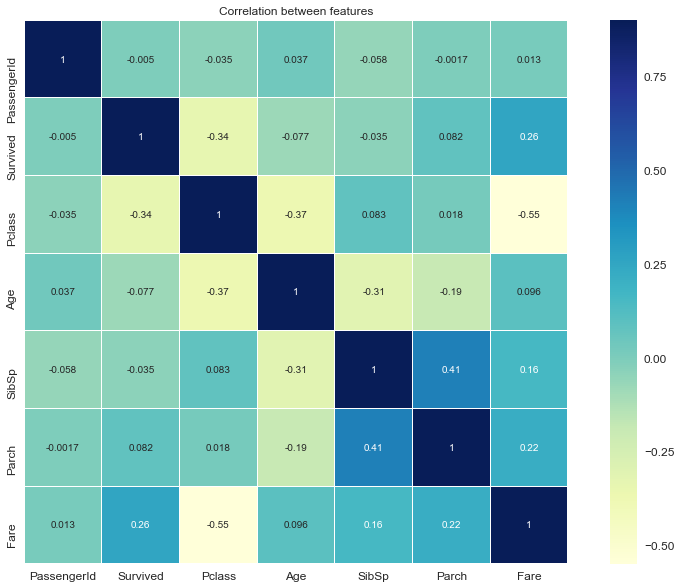

In [8]:
corr=titanic.corr()#["Survived"]
plt.figure(figsize=(15, 10))

sns.heatmap(corr, vmax=.9, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [9]:
#correlation of features with target variable
titanic.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

    It's visible that survival rate has the highest Positive Correlation with Fare followed by Parch and Highest negative correlation with Pclass followed by age.

### Step 5 - Data Pre-processing

    It's important to fill null values and scale the features before feeding the data into the model.

In [10]:
#Lets check which rows have null Embarked column
titanic[titanic['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


    Since both the records are from Pclass 1 in the same cabin as well, let's try to visualize the other similar records 

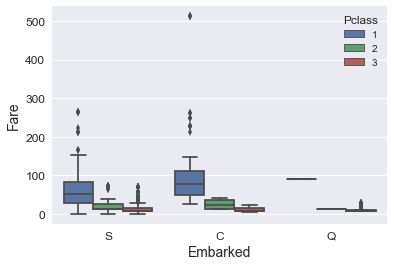

In [11]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=titanic);

In [12]:
titanic['Embarked'].describe()
#titanic['Pclass'].mean()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [13]:
titanic[titanic['Pclass']==1].sort_values(['PassengerId']).loc[0:70]
#titanic['Pclass'].mean()
#titanic[titanic['Fare'] ==80.0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S


In [14]:
#As it can be seen that other Cabin Passengers also majorly boarded from C
titanic["Embarked"] = titanic["Embarked"].fillna('C')

Also We can see that for 1st class median line is coming around fare $80 for embarked value 'C'. So we can replace NA values in Embarked column with 'C'

#### Fare Column

In [15]:
#we can replace missing value in fare by taking median of all fares of those passengers 
#who share 3rd Passenger class and Embarked from 'S' 

def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['Fare'].median()
#'S'
       #print(median_fare)
    df["Fare"] = df["Fare"].fillna(median_fare)
    return df

titanic_test=fill_missing_fare(titanic_test)

### Feature Engineering

#### 1. Deck - Where exactly were passenger on the ship?

In [16]:
titanic["Deck"]=titanic.Cabin.str[0]
titanic_test["Deck"]=titanic_test.Cabin.str[0]
titanic["Deck"].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

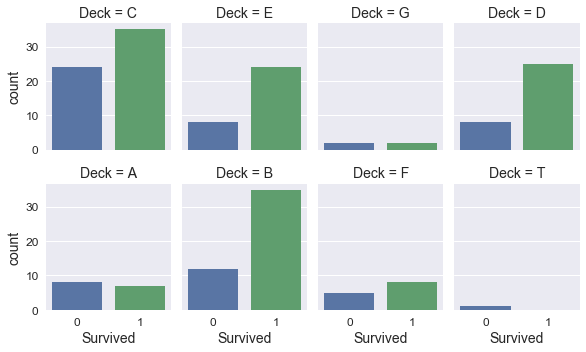

In [17]:
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=titanic[titanic.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

In [18]:
titanic.Deck.fillna('Z', inplace=True)
titanic_test.Deck.fillna('Z', inplace=True)
titanic["Deck"].unique() # Z is for null values

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

#### 2. How Big is your family?

In [19]:
# Creating a family size variable including the passenger themselves
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]+1
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]+1
print(titanic["FamilySize"].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [20]:
# Discretize family size
titanic.loc[titanic["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic.loc[(titanic["FamilySize"] > 1)  &  (titanic["FamilySize"] < 5) , "FsizeD"] = 'small'
titanic.loc[titanic["FamilySize"] >4, "FsizeD"] = 'large'

titanic_test.loc[titanic_test["FamilySize"] == 1, "FsizeD"] = 'singleton'
titanic_test.loc[(titanic_test["FamilySize"] >1) & (titanic_test["FamilySize"] <5) , "FsizeD"] = 'small'
titanic_test.loc[titanic_test["FamilySize"] >4, "FsizeD"] = 'large'
print(titanic["FsizeD"].unique())
print(titanic["FsizeD"].value_counts())

['small' 'singleton' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


#### 3. Do you have longer names?

In [21]:
#Create feture for length of name 
# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))
#print(titanic["NameLength"].value_counts())

bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
titanic['NlengthD'] = pd.cut(titanic['NameLength'], bins, labels=group_names)
titanic_test['NlengthD'] = pd.cut(titanic_test['NameLength'], bins, labels=group_names)
print(titanic["NlengthD"].unique())

[okay, good, short, long]
Categories (4, object): [short < okay < good < long]


#### 4. Name Title

In [22]:
import re

#A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


In [23]:
def add_titles(df):
    #Get all the titles and print how often each one occurs.
    titles = df["Name"].apply(get_title)
    #print(pd.value_counts(titles))
    #type(titles)
    #Add in the title column.
    df["Title"] = titles
    # Titles with very low cell counts to be combined to "rare" level
    rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
    # Also reassign mlle, ms, and mme accordingly
    df.loc[df["Title"] == "Mlle", "Title"] = 'Miss'
    df.loc[df["Title"] == "Ms", "Title"] = 'Miss'
    df.loc[df["Title"] == "Mme", "Title"] = 'Mrs'
    df.loc[df["Title"] == "Dona", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Lady", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Countess", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Capt", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Col", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Don", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Major", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Rev", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Sir", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
    df.loc[df["Title"] == "Dr", "Title"] = 'Rare Title'
    print(df["Title"].value_counts())
    return df

In [24]:
titanic = add_titles(titanic)

Mr            517
Miss          185
Mrs           126
Master         40
Rare Title     23
Name: Title, dtype: int64


In [25]:
titanic_test = add_titles(titanic_test)

Mr            240
Miss           79
Mrs            72
Master         21
Rare Title      6
Name: Title, dtype: int64


#### 5.Ticket Number extraction

In [26]:
print(titanic["Ticket"].tail())
titanic["TicketNumber"] = titanic["Ticket"].str.extract('(\d{2,})', expand=True)
titanic["TicketNumber"] = titanic["TicketNumber"].apply(pd.to_numeric)


titanic_test["TicketNumber"] = titanic_test["Ticket"].str.extract('(\d{2,})', expand=True)
titanic_test["TicketNumber"] = titanic_test["TicketNumber"].apply(pd.to_numeric)

886        211536
887        112053
888    W./C. 6607
889        111369
890        370376
Name: Ticket, dtype: object


In [27]:
#some rows in ticket column dont have numeric value so we got NaN there
titanic[titanic["TicketNumber"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,28,okay,Mr,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,31,okay,Mr,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5,E77,S,E,1,singleton,17,short,Mrs,NaN
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,Z,1,singleton,24,okay,Mr,NaN


In [28]:
titanic.TicketNumber.fillna(titanic["TicketNumber"].median(), inplace=True)
titanic_test.TicketNumber.fillna(titanic_test["TicketNumber"].median(), inplace=True)


#### 6. Categorical to Numeric Features.
    Using Label Encoder one at a time as Categorical Encoder is not available

In [29]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelEnc=LabelEncoder()
cat_vars=['Embarked','Sex',"Title","FsizeD","NlengthD",'Deck']
for col in cat_vars:
    titanic[col]=labelEnc.fit_transform(titanic[col])
    titanic_test[col]=labelEnc.fit_transform(titanic_test[col])

#### 7. Age
Age seems to be promising feature. So it doesnt make sense to simply fill null values out with median/mean/mode.
Using Random Forest algorithm to predict ages.

In [30]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
                 'TicketNumber', 'Title','Pclass','FamilySize',
                 'FsizeD','NameLength',"NlengthD",'Deck']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [31]:
titanic=fill_missing_age(titanic)
titanic_test=fill_missing_age(titanic_test)


    Scaling Age & Fare
   

In [32]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(titanic[['Age', 'Fare']])
titanic[['Age', 'Fare']] = std_scale.transform(titanic[['Age', 'Fare']])


std_scale = preprocessing.StandardScaler().fit(titanic_test[['Age', 'Fare']])
titanic_test[['Age', 'Fare']] = std_scale.transform(titanic_test[['Age', 'Fare']])


###### New Correleation

In [33]:
titanic.corr()["Survived"]

PassengerId    -0.005007
Survived        1.000000
Pclass         -0.338481
Sex            -0.543351
Age            -0.078606
SibSp          -0.035322
Parch           0.081629
Fare            0.257307
Embarked       -0.174199
Deck           -0.301116
FamilySize      0.016639
FsizeD          0.283810
NameLength      0.332350
NlengthD       -0.312234
Title          -0.071174
TicketNumber   -0.096161
Name: Survived, dtype: float64

### Step 6.  Model Building

#### 1. Linear Regression

In [34]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age","SibSp", "Parch", "Fare",
              "Embarked","NlengthD", "FsizeD", "Title","Deck"]
target="Survived"
# Initialize our algorithm class
lin_reg = LinearRegression()

# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []

c:\users\amita\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [35]:
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic[target].iloc[train]
    # Training the algorithm using the predictors and target.
    lin_reg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = lin_reg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [36]:
predictions = np.concatenate(predictions, axis=0)
# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0


accuracy=sum(titanic["Survived"]==predictions)/len(titanic["Survived"])
accuracy

0.8114478114478114

#### 2. Logistic Regression

In [37]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

predictors = ["Pclass", "Sex", "Fare", "Embarked","Deck","Age",
              "FsizeD", "NlengthD","Title","Parch"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

scores = cross_val_score(lr, titanic[predictors], 
                                          titanic["Survived"],scoring='f1', cv=cv)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.7617319280918632


#### 4. Random Forest

In [38]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict

import numpy as np
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, 
                            min_samples_leaf=1)
kf = KFold(titanic.shape[0], n_folds=5, random_state=1)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)

predictions = cross_validation.cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],
                                          scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.744670716088588


In [39]:
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD","NameLength", "FsizeD", "Title","Deck","TicketNumber"]
rf = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=9,min_samples_split=6, min_samples_leaf=4)
rf.fit(titanic[predictors],titanic["Survived"])
kf = KFold(titanic.shape[0], n_folds=5, random_state=1)
predictions = cross_validation.cross_val_predict(rf, titanic[predictors],titanic["Survived"],cv=kf)
predictions = pd.Series(predictions)
scores = cross_val_score(rf, titanic[predictors], titanic["Survived"],scoring='f1', cv=kf)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.7763975122437341


#### Important Features

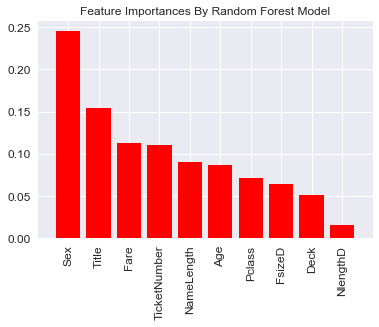

In [40]:
importances=rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
#predictors=titanic.columns
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

### Gradient Boosting

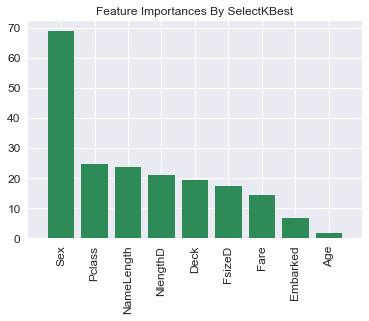

In [41]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import KFold
%matplotlib inline
import matplotlib.pyplot as plt
#predictors = ["Pclass", "Sex", "Age", "Fare",
 #             "FsizeD", "Embarked", "NlengthD","Deck","TicketNumber"]
predictors = ["Pclass", "Sex", "Age",
              "Fare","NlengthD", "FsizeD","NameLength","Deck","Embarked"]
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

indices = np.argsort(scores)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

plt.figure()
plt.title("Feature Importances By SelectKBest")
plt.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", yerr=std[indices], align="center")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)]);

In [42]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck"]

# Initialize our algorithm
lr = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=50)
scores = cross_val_score(lr, titanic[predictors], titanic["Survived"], scoring='f1',cv=cv)
print(scores.mean())

0.762857943195592


### Ensemble Model

In [43]:
predictions=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","NameLength","TicketNumber"]
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf)], voting='soft')
eclf1 = eclf1.fit(titanic[predictors], titanic["Survived"])
predictions=eclf1.predict(titanic[predictors])
#predictions
test_predictions=eclf1.predict(titanic_test[predictors])
test_predictions=test_predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)


c:\users\amita\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\amita\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [44]:
save_model(eclf1,'ensemble_model')